In [1]:
from nipype.interfaces import afni as afni

import numpy as np
import pandas as pd
import os as os
import re as re
import glob as glob
import nibabel as nibabel
from mvpa2.tutorial_suite import *



/Users/Jim/anaconda/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.weave` is deprecated, use `weave` instead!
  warnings.warn(depdoc, DeprecationWarning)


#### Notes

This notebook is a marriage of the redux analyses for SRP and some code I wrote to make getting subjects and making masks more progromatic. 

THis notebook was run on the data stored on SNI (so data that were aligned to the skull stripped brain from Fressurfer w/ a nim cost function).




## SETUP 

In [2]:
import nipype.interfaces.afni as afni
import os as os

def makeMask(subPrefix, labelFile, maskSuffix, fsLabels):
    
    """
    function to create a mask file for a list of freesurfer regions (fs)
        subPrefix (string):  ubject name to use
        
        maksSuffix (string): name to give restulting mask
    
        fsLabels (list of ints): set of regions to use in mask.
    """

    ## calc mask
    masksCalc = afni.Calc()
    masksCalc.inputs.in_file_a = labelFile
    masksCalc.inputs.expr = 'amongst(a, '+ ', '.join(str(l) for l in fsLabels)+ ')'
    masksCalc.inputs.out_file =  'calcmask'
    masksCalc.inputs.outputtype = "AFNI"
    print(masksCalc.cmdline)
    masksCalc.run()

    ## resample
    resamp = afni.Resample()
    resamp.inputs.in_file = 'calcmask+orig.BRIK'
    resamp.inputs.resample_mode = 'NN'
    resamp.inputs.master =  subPrefix + '.LSSbetas.BLOCK6.study.uber.nii' # resampling to func space
    resamp.inputs.out_file = subPrefix + '.' + maskSuffix +  '.nii'
    resamp.inputs.outputtype = "NIFTI"
    print(resamp.cmdline)
    resamp.run()

    os.remove('calcmask+orig.BRIK')
    os.remove('calcmask+orig.HEAD')

In [3]:
### SET Working directory

% cd /Users/Jim/PARC_data_special/mvpa_files/


/Users/Jim/PARC_data_special/mvpa_files


In [4]:
bothTest = pd.read_csv("/Users/Jim/Dropbox/Dissertation/data_files/bothTest_toMakeRegressors.csv")
subsFile = np.array(bothTest.Subject.unique())
subsFile_prefix  = np.array(['PARC_sub_' + str(s) for s in subsFile])


In [5]:
### get list of subs w/ file some file pattern

filePattern = ".labelVolume.nii.gz"
betaFiles = glob.glob('*' + filePattern  + '*')
subPrefixes = map(lambda f: re.sub(filePattern,"",f), betaFiles)
subNums = map(lambda f: re.sub("PARC_sub_","",f), subPrefixes)

print subPrefixes[0]
print subNums[0]


PARC_sub_2699
2699


In [6]:
## who is missing from data file? 
print "in file folder but not behave file" + str(subsFile_prefix[np.in1d(subPrefixes, subsFile_prefix, invert = True)])
print "in behave file but no filein folder " + str(subsFile_prefix[np.in1d(subsFile_prefix, subPrefixes, invert = True)])

in file folder but not behave file[]
in behave file but no filein folder ['PARC_sub_2908']


### Parameters to use - beta files, masks

In this notebook I've made the masks already (should be of format .nii)

In [7]:
#### set up data ####
# subjects = ['PARC_sub_2699', 'PARC_sub_2718', 'PARC_sub_2726', 'PARC_sub_2747', 'PARC_sub_2754', 'PARC_sub_2761', 'PARC_sub_2784', 'PARC_sub_2786', 'PARC_sub_2787',
#             'PARC_sub_2788', 'PARC_sub_2792', 'PARC_sub_2796', 'PARC_sub_2799', 'PARC_sub_2778', 'PARC_sub_2825', 'PARC_sub_2838', 'PARC_sub_2759']

# subjects = subPrefixes # subjects defined above

## files to use
# filePattern = ".labelVolume.nii.gz"
study_beta_prefix = 'LSSbetas.BLOCK6.study.uber'
test_beta_prefix = 'LSSbetas.GAM.test.uber'
mask_prefix = 'parafusi'
mask_labels = [1007, 2007, 1016, 2016]
csvName = 'mvpa_'+ mask_prefix +'_diss1_.csv'

subPrefixes.sort()
subjects = subPrefixes
# in scanner clarity cutoff
confidence_cutoff = 3
subjects

['PARC_sub_2699',
 'PARC_sub_2718',
 'PARC_sub_2726',
 'PARC_sub_2736',
 'PARC_sub_2747',
 'PARC_sub_2754',
 'PARC_sub_2759',
 'PARC_sub_2761',
 'PARC_sub_2778',
 'PARC_sub_2784',
 'PARC_sub_2786',
 'PARC_sub_2787',
 'PARC_sub_2788',
 'PARC_sub_2792',
 'PARC_sub_2796',
 'PARC_sub_2799',
 'PARC_sub_2825',
 'PARC_sub_2829',
 'PARC_sub_2834',
 'PARC_sub_2838',
 'PARC_sub_2841',
 'PARC_sub_2848',
 'PARC_sub_2853',
 'PARC_sub_2865',
 'PARC_sub_2874',
 'PARC_sub_2879',
 'PARC_sub_2885',
 'PARC_sub_2903',
 'PARC_sub_2917',
 'PARC_sub_2927',
 'PARC_sub_2938',
 'PARC_sub_2939',
 'PARC_sub_2945',
 'PARC_sub_2955',
 'PARC_sub_2956',
 'PARC_sub_2958',
 'PARC_sub_2967',
 'PARC_sub_2987',
 'PARC_sub_2993',
 'PARC_sub_3010']

In [8]:

for subj_n, subj in enumerate(subjects):
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'

    if not os.path.exists(study_beta_name):
        print "missing Study beta file for "  + subj 
    
    if not os.path.exists(test_beta_name):
        print "missing Test beta file for "  + subj 
        
    if not os.path.exists(mask_name):
        print "missing mask file for "  + subj         

missing Test beta file for PARC_sub_2829


In [9]:
# set subject list and remove the ones not wanted
subjects = subPrefixes


# sub 2908 - lots of movement
# 2829 - also lots of moevement? single beta estimation for run 5 of recall failed.

probSubs = ['PARC_sub_2908','PARC_sub_2844','PARC_sub_2829']

for s in probSubs:
    if(np.in1d(s,subjects)):
        print "removing " + str(s)
        subjects.remove(s)

removing PARC_sub_2829


### Make Masks

In [23]:
# I'm going to make masks with a script on the desktop.

# for subPrefix in subjects:
# #     subPrefix = 'PARC_sub_' + str(s)
#     maskName = subPrefix + '.' + mask_prefix + '.nii'
#     labelFileName = subPrefix + filePattern #output name
    
# #     print str(mask_labels)
#     if(os.path.exists(maskName)):
#         print maskName  + " Mask already exists for " + subPrefix
#     else: makeMask(subPrefix, labelFileName, mask_prefix, mask_labels)

In [10]:
behave_acc = []
inScan_acc = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    test_csv_name = subj + '_test_timingdata.csv'
    test_data = pd.read_csv(test_csv_name, sep=',')
    print subj
    print float(sum(test_data.finaltest_correct))/96
    behave_acc.append(float(sum(test_data.finaltest_correct))/96)
    inScan_acc.append(float(sum(test_data.corrected_resp > confidence_cutoff))/96)
    
    

PARC_sub_2699
0.229166666667
PARC_sub_2718
0.5
PARC_sub_2726
0.65625
PARC_sub_2736
0.697916666667
PARC_sub_2747
0.416666666667
PARC_sub_2754
0.510416666667
PARC_sub_2759
0.65625
PARC_sub_2761
0.395833333333
PARC_sub_2778
0.25
PARC_sub_2784
0.90625
PARC_sub_2786
0.260416666667
PARC_sub_2787
0.84375
PARC_sub_2788
0.4375
PARC_sub_2792
0.864583333333
PARC_sub_2796
0.635416666667
PARC_sub_2799
0.40625
PARC_sub_2825
0.614583333333
PARC_sub_2834
0.302083333333
PARC_sub_2838
0.645833333333
PARC_sub_2841
0.614583333333
PARC_sub_2848
0.75
PARC_sub_2853
0.75
PARC_sub_2865
0.802083333333
PARC_sub_2874
0.822916666667
PARC_sub_2879
0.166666666667
PARC_sub_2885
0.6875
PARC_sub_2903
0.229166666667
PARC_sub_2917
0.270833333333
PARC_sub_2927
0.458333333333
PARC_sub_2938
0.4375
PARC_sub_2939
0.15625
PARC_sub_2945
0.552083333333
PARC_sub_2955
0.28125
PARC_sub_2956
0.5
PARC_sub_2958
0.416666666667
PARC_sub_2967
0.0729166666667
PARC_sub_2987
0.354166666667
PARC_sub_2993
0.375
PARC_sub_3010
0.53125


In [11]:
study_accuracy = []

for subj_n, subj in enumerate(subjects):
    
    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
#    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    
    ### CV study
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
    cv_results = cvte(ds_study)
    print subj + '  ' + str(np.mean(cv_results))
    study_accuracy.append(np.mean(cv_results))

loading neural data...
CV study/n
PARC_sub_2699  0.9375
loading neural data...
CV study/n
PARC_sub_2718  0.927083333333
loading neural data...
CV study/n
PARC_sub_2726  0.833333333333
loading neural data...
CV study/n
PARC_sub_2736  0.90625
loading neural data...
CV study/n
PARC_sub_2747  0.927083333333
loading neural data...
CV study/n
PARC_sub_2754  0.927083333333
loading neural data...
CV study/n
PARC_sub_2759  0.927083333333
loading neural data...
CV study/n
PARC_sub_2761  0.895833333333
loading neural data...
CV study/n
PARC_sub_2778  0.979166666667
loading neural data...
CV study/n
PARC_sub_2784  0.96875
loading neural data...
CV study/n
PARC_sub_2786  0.916666666667
loading neural data...
CV study/n
PARC_sub_2787  0.979166666667
loading neural data...
CV study/n
PARC_sub_2788  0.96875
loading neural data...
CV study/n
PARC_sub_2792  0.947916666667
loading neural data...
CV study/n
PARC_sub_2796  0.958333333333
loading neural data...
CV study/n
PARC_sub_2799  0.885416666667
loadi

In [12]:
trainstudy_test_hicon_accuracy = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)
    
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    ds_test.sa['corrected_resp'] = test_data.corrected_resp
    ds_totest = ds_test[np.array(ds_test.sa.corrected_resp > confidence_cutoff)]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_totest.samples)
    results = np.mean(predictions == ds_totest.sa.targets) 
    
    print subj +  'N trials correct: ' + str(len(predictions)) + ' CV acc: ' + str(results) 

    trainstudy_test_hicon_accuracy.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 49 CV acc: 0.65306122449
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 54 CV acc: 0.777777777778
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 82 CV acc: 0.634146341463
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 81 CV acc: 0.753086419753
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 43 CV acc: 0.558139534884
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 40 CV acc: 0.8
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 80 CV acc: 0.8375
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 63 CV acc: 0.619047619048
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 43 CV acc: 0.604651162791
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 96 CV acc: 0.625
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 44 CV acc: 0.681818181818
loading neural data...
CV st

In [13]:
ds_test.sa['corrected_resp'] = test_data.corrected_resp
ds_totest = ds_test[np.array(ds_test.sa.corrected_resp > confidence_cutoff)]


In [14]:
test_accuracy = []


for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
#    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_test)
 
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
    cv_results = cvte(ds_test)
    print subj +  'N trials correct: ' + str(sum(test_data.finaltest_correct)) + ' CV acc: ' + str(np.mean(cv_results)) 
    test_accuracy.append(np.mean(cv_results))
 

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 22 CV acc: 0.614583333333
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 48 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 63 CV acc: 0.697916666667
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 67 CV acc: 0.791666666667
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 40 CV acc: 0.739583333333
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 49 CV acc: 0.71875
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 63 CV acc: 0.75
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 38 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 24 CV acc: 0.520833333333
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 87 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 25 CV acc: 0.666666666667
loading neural d

In [15]:
trainstudy_test_cor_accuracy = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)
    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    
    correctonly_test = test_data[np.array(test_data.finaltest_correct==1)]
    correct_test_labels = correctonly_test.imgType
    ds_test.sa['final_corect'] = test_data.finaltest_correct
    ds_totest = ds_test[np.array(ds_test.sa.final_corect==1)]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_totest.samples)
    results = np.mean(predictions == ds_totest.sa.targets) 
    
    print subj +  'N trials correct: ' + str(sum(test_data.finaltest_correct)) + ' CV acc: ' + str(results) 

    trainstudy_test_cor_accuracy.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 22 CV acc: 0.636363636364
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 48 CV acc: 0.708333333333
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 63 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 67 CV acc: 0.776119402985
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 40 CV acc: 0.575
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 49 CV acc: 0.816326530612
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 63 CV acc: 0.84126984127
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 38 CV acc: 0.605263157895
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 24 CV acc: 0.541666666667
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 87 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 25 CV acc: 0.76
loading neural data

In [16]:
trainstudy_test_incor_accuracy = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)
    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    
    correctonly_test = test_data[test_data.finaltest_correct==0]
    correct_test_labels = correctonly_test.imgType
    ds_test.sa['final_corect'] = test_data.finaltest_correct
    ds_totest = ds_test[np.array(ds_test.sa.final_corect==0)]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_totest.samples)
    results = np.mean(predictions == ds_totest.sa.targets) 
    
    print subj +  'N trials correct: ' + str(len(predictions)) + ' CV acc: ' + str(results) 

    trainstudy_test_incor_accuracy.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 74 CV acc: 0.554054054054
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 48 CV acc: 0.708333333333
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 33 CV acc: 0.545454545455
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 29 CV acc: 0.689655172414
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 56 CV acc: 0.571428571429
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 47 CV acc: 0.617021276596
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 33 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 58 CV acc: 0.637931034483
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 72 CV acc: 0.597222222222
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 9 CV acc: 0.222222222222
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 71 CV acc: 0.535211267606


In [17]:
#### accurate and confident 

trainstudy_test_hicon_cor = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)
    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    
    ds_test.sa['corrected_resp'] = test_data.corrected_resp
    ds_test.sa['final_corect'] = test_data.finaltest_correct
    ds_totest = ds_test[np.array(ds_test.sa.corrected_resp > confidence_cutoff)]
    ds_totest = ds_totest[np.array(ds_totest.sa.final_corect==1)]
#     correct_test_labels = ds_totest.sa.imgType
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_totest.samples)
    results = np.mean(predictions == ds_totest.sa.targets) 
    
    print subj +  'N trials correct: ' +  str(len(predictions)) + ' CV acc: ' + str(results) 

    trainstudy_test_hicon_cor.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 21 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 40 CV acc: 0.75
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 62 CV acc: 0.677419354839
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 63 CV acc: 0.777777777778
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 35 CV acc: 0.571428571429
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 31 CV acc: 0.806451612903
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 61 CV acc: 0.868852459016
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 38 CV acc: 0.605263157895
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 22 CV acc: 0.545454545455
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 87 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 21 CV acc: 0.809523809524
loading n

In [18]:
# ds_test.sa['corrected_resp'] = test_data.corrected_resp
# ds_test.sa['final_corect'] = test_data.finaltest_correct
# ds_totest = ds_test[np.array(ds_test.sa.corrected_resp > confidence_cutoff)]
# ds_totest = ds_totest[np.array(ds_totest.sa.final_corect==1)]

# ds_totest.sa

In [19]:
trainstudy_test_all_accuracy = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)

    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    
#     correctonly_test = test_data[test_data.finaltest_correct==0]
#     correct_test_labels = correctonly_test.imgType
#     ds_test.sa['final_corect'] = test_data.finaltest_correct
#     ds_totest = ds_test[ds_test.sa.final_corect==0]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_test.samples)
    results = np.mean(predictions == ds_test.sa.targets) 
    
    print subj +  'N trials correct: ' + str(len(predictions)) + ' CV acc: ' + str(results) 

    trainstudy_test_all_accuracy.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 96 CV acc: 0.572916666667
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 96 CV acc: 0.708333333333
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 96 CV acc: 0.625
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 96 CV acc: 0.75
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 96 CV acc: 0.572916666667
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 96 CV acc: 0.71875
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 96 CV acc: 0.78125
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 96 CV acc: 0.625
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 96 CV acc: 0.583333333333
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 96 CV acc: 0.625
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 96 CV acc: 0.59375
loading neural data...
CV study/n
PARC_sub_2787N trials c

In [20]:
# ds_totest[np.array(ds_totest.sa.final_corect==1)]

In [21]:
test_cor_accuracy = []


for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
#    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_test)
    ### CV TEST
#     print 'CV study/n'
#     clf = LinearCSVMC(C=-1)
#     cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
#     cv_results = cvte(ds_test)
#     print subj + '  ' + str(np.mean(cv_results))

    correctonly_test = test_data[test_data.finaltest_correct==1]
    correct_test_labels = correctonly_test.imgType
    ds_test.sa['final_corect'] = test_data.finaltest_correct
    ds_totest = ds_test[np.array(ds_test.sa.final_corect==1)]
    
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
    cv_results = cvte(ds_totest)
    print subj +  'N trials correct: ' + str(sum(test_data.finaltest_correct)) + ' CV acc: ' + str(np.mean(cv_results)) 
    test_cor_accuracy.append(np.mean(cv_results))

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 22 CV acc: 0.477777777778
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 48 CV acc: 0.637896825397
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 63 CV acc: 0.668434343434
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 67 CV acc: 0.840326340326
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 40 CV acc: 0.65
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 49 CV acc: 0.606854256854
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 63 CV acc: 0.764194139194
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 38 CV acc: 0.533068783069
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 24 CV acc: 0.347222222222
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 87 CV acc: 0.696604090354
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 25 CV acc: 0.450793650794
loading n

In [22]:

trainstudy_test_lowcon_accuracy = []

for subj_n, subj in enumerate(subjects):

    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)
    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    

    correctonly_test = test_data[test_data.corrected_resp < confidence_cutoff]
    correct_test_labels = correctonly_test.imgType
    ds_test.sa['corrected_resp'] = test_data.corrected_resp
    ds_totest = ds_test[np.array(ds_test.sa.corrected_resp < confidence_cutoff)]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_totest.samples)
    results = np.mean(predictions == ds_totest.sa.targets) 
    
    print subj +  'N trials correct: ' + str(len(predictions))+ ' CV acc: ' + str(results) 

    trainstudy_test_lowcon_accuracy.append(results)

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 36 CV acc: 0.5
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 21 CV acc: 0.52380952381
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 12 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 11 CV acc: 0.727272727273
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 29 CV acc: 0.48275862069
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 30 CV acc: 0.533333333333
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 6 CV acc: 0.666666666667
loading neural data...
CV study/n
PARC_sub_2761N trials correct: 24 CV acc: 0.583333333333
loading neural data...
CV study/n
PARC_sub_2778N trials correct: 37 CV acc: 0.513513513514
loading neural data...
CV study/n
PARC_sub_2784N trials correct: 0 CV acc: 0.0
loading neural data...
CV study/n
PARC_sub_2786N trials correct: 21 CV acc: 0.380952380952
loading neural data...
CV

In [23]:

# combine  accuracy information 

mvpa_data_dict = {'subject' : subjects,
                  'encode_acc' : study_accuracy,
                  'inScan_hiClear_pct': inScan_acc,
                  'recall_cor_acc' : test_cor_accuracy,
                  'ENCrec_all_cor_acc': trainstudy_test_cor_accuracy,
                  'behave_acc' : behave_acc ,
                  'ENCrec_all_incor_acc' : trainstudy_test_incor_accuracy ,
                  'recall_all_acc' : test_accuracy,
                  'ENCrec_all': trainstudy_test_all_accuracy,
                  'hicon_ENCrec' : trainstudy_test_hicon_accuracy,
                  'lowcon_ENCrec' : trainstudy_test_lowcon_accuracy,
                  'ENCrec_hicon3_cor': trainstudy_test_hicon_cor
                  }
mvpa_data = pd.DataFrame(mvpa_data_dict)
mvpa_data

,ENCrec_all,ENCrec_all_cor_acc,ENCrec_all_incor_acc,ENCrec_hicon3_cor,behave_acc,encode_acc,hicon_ENCrec,inScan_hiClear_pct,lowcon_ENCrec,recall_all_acc,recall_cor_acc,subject
0,0.572917,0.636364,0.554054,0.666667,0.229167,0.937500,0.653061,0.510417,0.500000,0.614583,0.477778,PARC_sub_2699
1,0.708333,0.708333,0.708333,0.750000,0.500000,0.927083,0.777778,0.562500,0.523810,0.666667,0.637897,PARC_sub_2718
2,0.625000,0.666667,0.545455,0.677419,0.656250,0.833333,0.634146,0.854167,0.666667,0.697917,0.668434,PARC_sub_2726
3,0.750000,0.776119,0.689655,0.777778,0.697917,0.906250,0.753086,0.843750,0.727273,0.791667,0.840326,PARC_sub_2736
4,0.572917,0.575000,0.571429,0.571429,0.416667,0.927083,0.558140,0.447917,0.482759,0.739583,0.650000,PARC_sub_2747
5,0.718750,0.816327,0.617021,0.806452,0.510417,0.927083,0.800000,0.416667,0.533333,0.718750,0.606854,PARC_sub_2754
6,0.781250,0.841270,0.666667,0.868852,0.656250,0.927083,0.837500,0.833333,0.666667,0.750000,0.764194,PARC_sub_2759
7,0.625000,0.605263,0.637931,0.605263,0.395833,0.895833,0.619048,0.656250,0.583333,0.666667,0.533069,PARC_sub_2761
8,0.583333,0.541667,0.597222,0.545455,0.250000,0.979167,0.604651,0.447917,0.513514,0.520833,0.347222,PARC_sub_2778
9,0.625000,0.666667,0.222222,0.666667,0.906250,0.968750,0.625000,1.000000,0.000000,0.666667,0.696604,PARC_sub_2784


In [63]:
# mvpa_data_old = mvpa_data
# mvpa_data_old = mvpa_data_old.append(mvpa_data)
# mvpa_data = mvpa_data_old

In [24]:
mvpa_data['aparcType'] = ['Marissa']*mvpa_data.shape[0]
mvpa_data['roi'] = [mask_prefix]* mvpa_data.shape[0]

In [25]:
# csvname = 'mvpa_'+ maskSuffix +'_forSRP_.csv'

csvName = 'mvpa_'+ mask_prefix +'_newAlign_fix2736_.csv'
pd.DataFrame.to_csv(mvpa_data,csvName)

In [77]:
csvName

'mvpa_parafusi_newAlign_.csv'

## quick plotting of findings. 

In [26]:
%matplotlib inline
import seaborn as sns


In [28]:
# subInfo = pd.read_csv("/Users/Jim/Dropbox/Dissertation/analysis tracking/subInfo.csv")
# mvpa_withSub = mvpa_data.merge(subInfo)

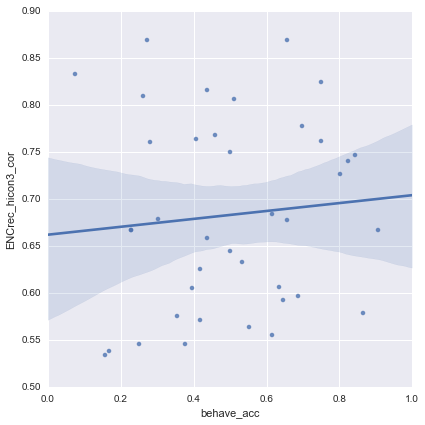

In [29]:


pal = sns.cubehelix_palette(4, 1.5, .75, light=.6, dark=.2)
g = sns.lmplot("behave_acc", "ENCrec_hicon3_cor", data=mvpa_data,
               palette=pal, size=6)




In [1]:
g = sns.lmplot("behave_acc", "encode_acc", data=mvpa_data,
               palette=pal, size=6)
# that's nice.

NameError: name 'sns' is not defined

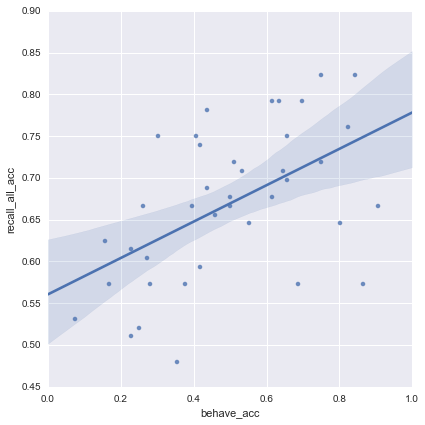

In [31]:
g = sns.lmplot("behave_acc","recall_all_acc",  data=mvpa_data,
               palette=pal, size=6)


this is pretty interesting. it looks like above chance CV classification for participants who did not so great a job on the final memory test!

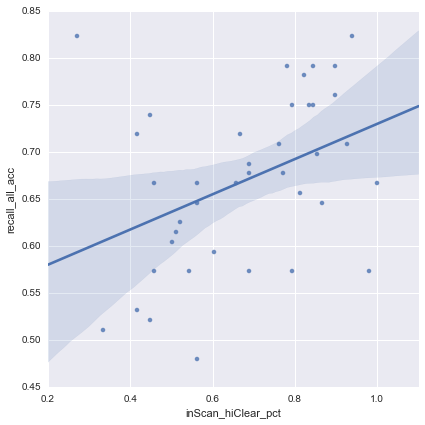

In [32]:

# g = sns.lmplot("behave_acc","inScan_hiClear_pct",  data=mvpa_data,
#                palette=pal, size=6)

g = sns.lmplot("inScan_hiClear_pct","recall_all_acc",  data=mvpa_data,
               palette=pal, size=6)

###  Get predictions in long form


In [89]:
longForm = pd.DataFrame()

for subj_n, subj in enumerate(subjects):

    predDf = pd.DataFrame()
    
    # load behavioral data
    study_csv_name = subj + '_study_timingdata.csv'
    test_csv_name = subj + '_test_timingdata.csv'
    study_data = pd.read_csv(study_csv_name, sep=',')
    test_data = pd.read_csv(test_csv_name, sep=',')
    
    # make variables to load neural data
    study_labels = list(study_data.imgType)
    test_labels = list(test_data.imgType)
    trials = np.array(range(1,97))
    runs = np.repeat(range(1,7),16, axis= 0)
    
    # load neural data 
    print 'loading neural data...' 
    study_beta_name = subj + '.' + study_beta_prefix + '.nii'
    mask_name = subj + '.' + mask_prefix + '.nii'
    test_beta_name = subj + '.' + test_beta_prefix + '.nii'
 
    ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
    ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
    zscore(ds_study)
    zscore(ds_test)

    ### CV TEST
    print 'CV study/n'
    clf = LinearCSVMC(C=-1)
    
    
#     correctonly_test = test_data[test_data.finaltest_correct==0]
#     correct_test_labels = correctonly_test.imgType
#     ds_test.sa['final_corect'] = test_data.finaltest_correct
#     ds_totest = ds_test[ds_test.sa.final_corect==0]
    
    clf = LinearCSVMC(C=-1)
    clf.train(ds_study)
    predictions = clf.predict(ds_test.samples)
    results = np.mean(predictions == ds_test.sa.targets)
    
    predDf['predictions'] = np.array(predictions)
    predDf['subID'] = subj
    predDf['imgFile'] = np.array(test_data.imgFile)
    predDf['trueLabel'] = np.array(test_data.imgType)
    
    
    
    print subj +  'N trials correct: ' + str(len(predictions)) + ' CV acc: ' + str(results) 
    print subj +  'N trials correct: (from dF)' + str(sum(predDf.predictions == predDf.trueLabel)) + ' CV acc: ' + str(results) 
    
    longForm = longForm.append(predDf)
    

loading neural data...
CV study/n
PARC_sub_2699N trials correct: 96 CV acc: 0.572916666667
PARC_sub_2699N trials correct: (from dF)55 CV acc: 0.572916666667
loading neural data...
CV study/n
PARC_sub_2718N trials correct: 96 CV acc: 0.708333333333
PARC_sub_2718N trials correct: (from dF)68 CV acc: 0.708333333333
loading neural data...
CV study/n
PARC_sub_2726N trials correct: 96 CV acc: 0.625
PARC_sub_2726N trials correct: (from dF)60 CV acc: 0.625
loading neural data...
CV study/n
PARC_sub_2736N trials correct: 96 CV acc: 0.5625
PARC_sub_2736N trials correct: (from dF)54 CV acc: 0.5625
loading neural data...
CV study/n
PARC_sub_2747N trials correct: 96 CV acc: 0.572916666667
PARC_sub_2747N trials correct: (from dF)55 CV acc: 0.572916666667
loading neural data...
CV study/n
PARC_sub_2754N trials correct: 96 CV acc: 0.71875
PARC_sub_2754N trials correct: (from dF)69 CV acc: 0.71875
loading neural data...
CV study/n
PARC_sub_2759N trials correct: 96 CV acc: 0.78125
PARC_sub_2759N trials 

In [93]:
pd.DataFrame.to_csv(longForm,"longForm_svm.csv")

""


play around w/ pymvpa classifier...

In [94]:
clf = LinearCSVMC(C=-1, probability = 1)


In [95]:
clf.train(ds_study)


In [98]:
clf.predict(ds_test.samples)


LinearSVMWeights(clf=LinearCSVMC(svm_impl='C_SVC', kernel=LinearLSKernel(), probability=1), auto_train=True, force_train=True)

In [118]:

### let's try switching the way that the classifier works. try using stuff from sci-kit

subj = 'PARC_sub_2699'

# load behavioral data
study_csv_name = subj + '_study_timingdata.csv'
test_csv_name = subj + '_test_timingdata.csv'
study_data = pd.read_csv(study_csv_name, sep=',')
test_data = pd.read_csv(test_csv_name, sep=',')

# make variables to load neural data
study_labels = list(study_data.imgType)
test_labels = list(test_data.imgType)
trials = np.array(range(1,97))
runs = np.repeat(range(1,7),16, axis= 0)

# load neural data 
print 'loading neural data...' 
study_beta_name = subj + '.' + study_beta_prefix + '.nii'
mask_name = subj + '.' + mask_prefix + '.nii'
test_beta_name = subj + '.' + test_beta_prefix + '.nii'

ds_study = fmri_dataset(samples = study_beta_name, mask = mask_name, chunks= runs, targets=study_labels)
zscore(ds_study)

ds_test = fmri_dataset(samples = test_beta_name, mask = mask_name, chunks= runs, targets=test_labels)
zscore(ds_test)

loading neural data...


In [60]:
from sklearn.linear_model import LogisticRegression
from mvpa2.clfs.skl.base import SKLLearnerAdapter

classifier = SKLLearnerAdapter(LogisticRegression(penalty='l2', C=1.))



# ### CV study
# print 'CV study/n'
# clf = LinearCSVMC(C=-1)
# cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
# cv_results = cvte(ds_study)
# print subj + '  ' + str(np.mean(cv_results))
# study_accuracy.append(np.mean(cv_results))

In [115]:
# clf = LinearCSVMC(C=-1)
cvte = CrossValidation(classifier, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
cvte(ds_study)
cvte.ca.stats.stats

{'# of labels': 2,
 '# of sets': 6,
 'ACC': 0.83333333333333337,
 'ACC%': 83.333333333333343,
 'AUC': [0.77083333333333337, 0.89583333333333337],
 'CHI^2': (42.833333333333329, 2.6699102936172296e-09),
 'CORR': 80,
 'F1': array([ 0.83673469,  0.82978723]),
 'FDR': array([ 0.18      ,  0.15217391]),
 'FN': array([7, 9]),
 'FP': array([9, 7]),
 'LOE(ACC):inter': 0.79761904761904767,
 'LOE(ACC):p': 0.41443008250091667,
 'LOE(ACC):r': 0.41403933560541251,
 'LOE(ACC):slope': 0.014285714285714285,
 'MCC': array([ 0.66724612,  0.66724612]),
 'N': array([48, 48]),
 "N'": array([46, 50]),
 'NPV': array([ 0.84782609,  0.82      ]),
 'P': array([48, 48]),
 "P'": array([50, 46]),
 'PPV': array([ 0.82      ,  0.84782609]),
 'SPC': array([ 0.8125    ,  0.85416667]),
 'TN': array([39, 41]),
 'TP': array([41, 39]),
 'TPR': array([ 0.85416667,  0.8125    ]),
 'mean(# of labels)': 2.0,
 'mean(ACC%)': 83.333333333333343,
 'mean(ACC)': 0.83333333333333337,
 'mean(AUC)': 0.83333333333333337,
 'mean(CHI^2)'

In [116]:
clf = LinearCSVMC(C=-1)
clf.get_sensitivity_analyzer()
cvte = CrossValidation(clf, NFoldPartitioner(),errorfx=lambda p, t: np.mean(p == t),enable_ca=['stats'])
cvte(ds_study)
cvte.ca.stats.stats

{'# of labels': 2,
 '# of sets': 6,
 'ACC': 0.85416666666666663,
 'ACC%': 85.416666666666657,
 'AUC': [0.90625, 0.90625],
 'CHI^2': (48.833333333333329, 1.4154994228649734e-10),
 'CORR': 82,
 'F1': array([ 0.86      ,  0.84782609]),
 'FDR': array([ 0.17307692,  0.11363636]),
 'FN': array([5, 9]),
 'FP': array([9, 5]),
 'LOE(ACC):inter': 0.80952380952380953,
 'LOE(ACC):p': 0.38093921047718865,
 'LOE(ACC):r': 0.44136741475237479,
 'LOE(ACC):slope': 0.01785714285714286,
 'MCC': array([ 0.71080571,  0.71080571]),
 'N': array([48, 48]),
 "N'": array([44, 52]),
 'NPV': array([ 0.88636364,  0.82692308]),
 'P': array([48, 48]),
 "P'": array([52, 44]),
 'PPV': array([ 0.82692308,  0.88636364]),
 'SPC': array([ 0.8125    ,  0.89583333]),
 'TN': array([39, 43]),
 'TP': array([43, 39]),
 'TPR': array([ 0.89583333,  0.8125    ]),
 'mean(# of labels)': 2.0,
 'mean(ACC%)': 85.416666666666657,
 'mean(ACC)': 0.85416666666666663,
 'mean(AUC)': 0.90625,
 'mean(CHI^2)': 24.416666666737438,
 'mean(CORR)': 